# **MNIST & MLP**

Dans ce notebook, nous allons entraîner un modèle perceptron multicouche pour classer les chiffres MNIST en utilisant PyTorch.



In [3]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
import os

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

Using PyTorch version: 2.3.0+cu121
No GPU found, using CPU instead.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Définir les transformations pour normaliser les données
transform = transforms.Compose(
    [transforms.ToTensor()])

# Charger les données CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

# Définir l'autoencodeur MLP en utilisant nn.Sequential
class MLP_Autoencoder(nn.Module):
    def __init__(self):
        super(MLP_Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3 * 32 * 32, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128)
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 3 * 32 * 32),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 3, 32, 32)
        return x

# Définir l'autoencodeur CNN
class CNN_Autoencoder(nn.Module):
    def __init__(self):
        super(CNN_Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # [batch, 16, 16, 16]
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # [batch, 32, 8, 8]
            nn.ReLU(True),
            nn.Conv2d(32, 64, 7)                      # [batch, 64, 2, 2]
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),            # [batch, 32, 8, 8]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # [batch, 16, 16, 16]
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Fonction pour entraîner l'autoencodeur
def train_autoencoder(model, trainloader, criterion, optimizer, epochs=10):
    train_loss = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, _ in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss.append(running_loss / len(trainloader))
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}")
    return train_loss

# Fonction pour tester l'autoencodeur
def test_autoencoder(model, testloader):
    with torch.no_grad():
        for inputs, _ in testloader:
            outputs = model(inputs)
            break
    return inputs, outputs

# Fonction pour afficher les courbes de perte
def plot_loss(train_loss, title):
    epochs = range(1, len(train_loss) + 1)
    plt.figure()
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Fonction pour afficher les images d'entrée et de sortie
def plot_images(inputs, outputs, title):
    inputs = inputs.numpy()
    outputs = outputs.numpy()
    fig, axes = plt.subplots(2, 6, figsize=(12, 4))
    for i in range(6):
        axes[0, i].imshow(np.transpose(inputs[i], (1, 2, 0)))
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        axes[1, i].imshow(np.transpose(outputs[i], (1, 2, 0)))
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')
    plt.suptitle(title)
    plt.show()

# # Entraîner et tester l'autoencodeur MLP
# mlp_autoencoder = MLP_Autoencoder()
criterion = nn.MSELoss()
# optimizer = optim.Adam(mlp_autoencoder.parameters(), lr=0.001)

# print("Training MLP Autoencoder...")
# mlp_train_loss = train_autoencoder(mlp_autoencoder, trainloader, criterion, optimizer, epochs=10)
# plot_loss(mlp_train_loss, "MLP Autoencoder Training Loss")

# print("Testing MLP Autoencoder...")
# mlp_inputs, mlp_outputs = test_autoencoder(mlp_autoencoder, testloader)
# plot_images(mlp_inputs, mlp_outputs, "MLP Autoencoder")

# # Entraîner et tester l'autoencodeur CNN
# cnn_autoencoder = CNN_Autoencoder()
# optimizer = optim.Adam(cnn_autoencoder.parameters(), lr=0.001)

# print("Training CNN Autoencoder...")
# cnn_train_loss = train_autoencoder(cnn_autoencoder, trainloader, criterion, optimizer, epochs=10)
# plot_loss(cnn_train_loss, "CNN Autoencoder Training Loss")

# print("Testing CNN Autoencoder...")
# cnn_inputs, cnn_outputs = test_autoencoder(cnn_autoencoder, testloader)
# plot_images(cnn_inputs, cnn_outputs, "CNN Autoencoder")


Files already downloaded and verified
Files already downloaded and verified


Training Deep CNN Autoencoder...
Epoch 1, Loss: 0.020276561684906484
Epoch 2, Loss: 0.01031373045966029
Epoch 3, Loss: 0.008356686506420375
Epoch 4, Loss: 0.00713165926001966
Epoch 5, Loss: 0.006152188666164875
Epoch 6, Loss: 0.00547842584643513
Epoch 7, Loss: 0.0049346698196604845
Epoch 8, Loss: 0.004484939915128053
Epoch 9, Loss: 0.004222374628763646
Epoch 10, Loss: 0.003977940283250063


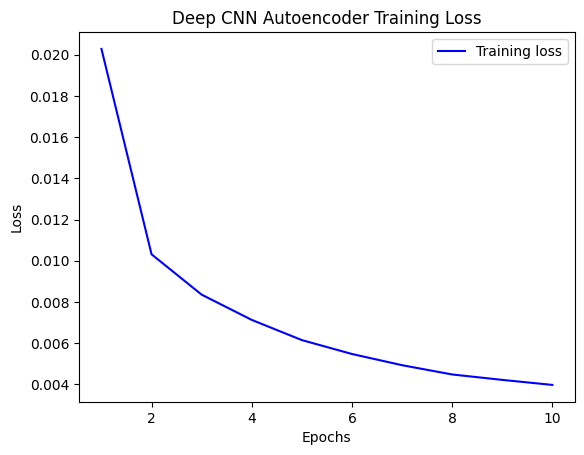

Testing Deep CNN Autoencoder...


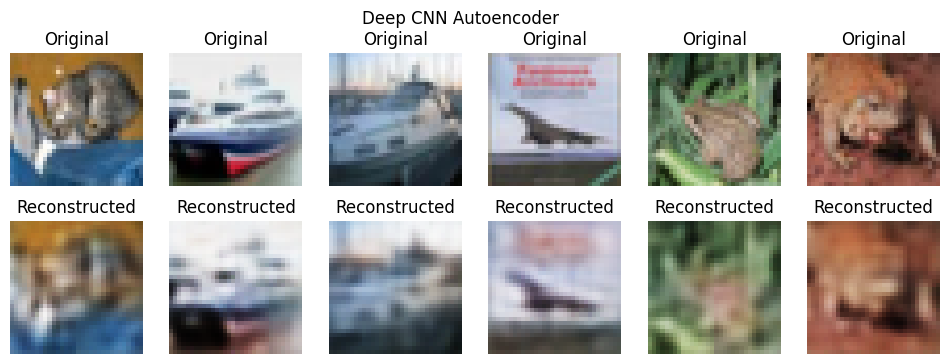

In [8]:
class Deep_CNN_Autoencoder(nn.Module):
    def __init__(self):
        super(Deep_CNN_Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),  # [batch, 32, 16, 16]
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # [batch, 64, 8, 8]
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), # [batch, 128, 4, 4]
            nn.ReLU(True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), # [batch, 256, 2, 2]
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  # [batch, 128, 4, 4]
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),   # [batch, 64, 8, 8]
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),   # [batch, 32, 16, 16]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Entraîner et tester l'autoencodeur CNN profond
deep_cnn_autoencoder = Deep_CNN_Autoencoder()
optimizer = optim.Adam(deep_cnn_autoencoder.parameters(), lr=0.001)

print("Training Deep CNN Autoencoder...")
deep_cnn_train_loss = train_autoencoder(deep_cnn_autoencoder, trainloader, criterion, optimizer, epochs=10)
plot_loss(deep_cnn_train_loss, "Deep CNN Autoencoder Training Loss")

print("Testing Deep CNN Autoencoder...")
deep_cnn_inputs, deep_cnn_outputs = test_autoencoder(deep_cnn_autoencoder, testloader)
plot_images(deep_cnn_inputs, deep_cnn_outputs, "Deep CNN Autoencoder")


Files already downloaded and verified
Files already downloaded and verified
Training MLP...
Epoch 1, Loss: 1.6610192873477936, Accuracy: 41.312%
Epoch 2, Loss: 1.4204097158908844, Accuracy: 50.164%
Epoch 3, Loss: 1.3012123504877091, Accuracy: 54.094%
Epoch 4, Loss: 1.2144583439826966, Accuracy: 57.114%
Epoch 5, Loss: 1.1343114265203476, Accuracy: 60.056%
Epoch 6, Loss: 1.0601990257501601, Accuracy: 62.714%
Epoch 7, Loss: 1.0013672207593918, Accuracy: 64.658%
Epoch 8, Loss: 0.9332317452430725, Accuracy: 67.086%
Epoch 9, Loss: 0.8728506579399109, Accuracy: 69.122%
Epoch 10, Loss: 0.8062853965759277, Accuracy: 71.586%
Testing MLP...
Accuracy: 53.02%
Time taken: 187.13538932800293 seconds


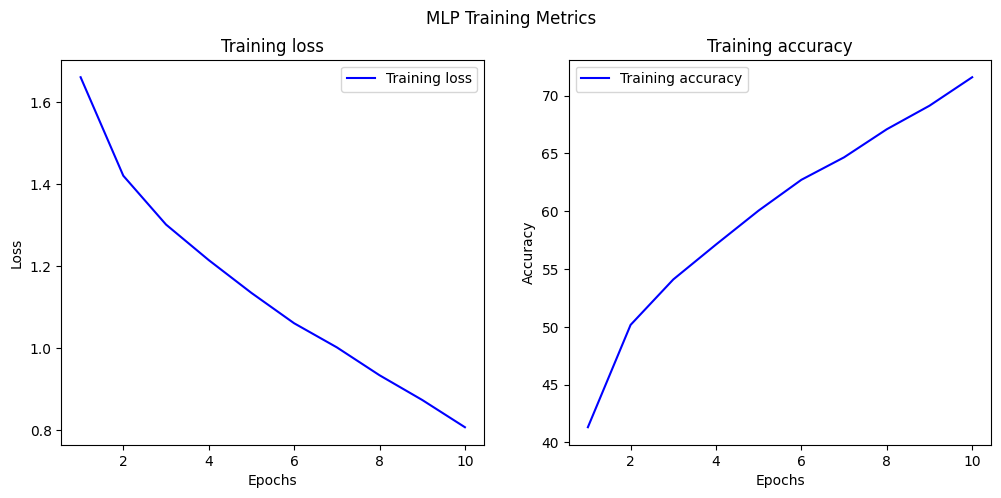

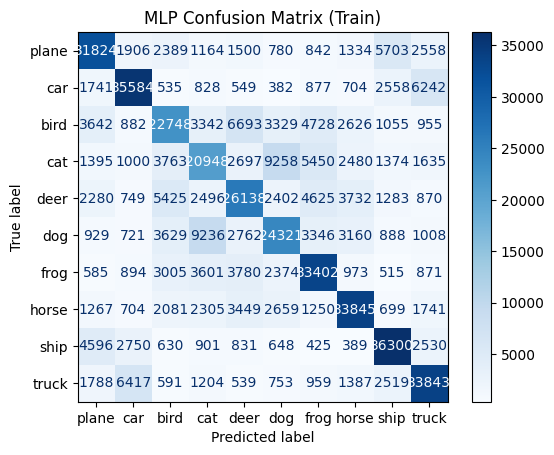

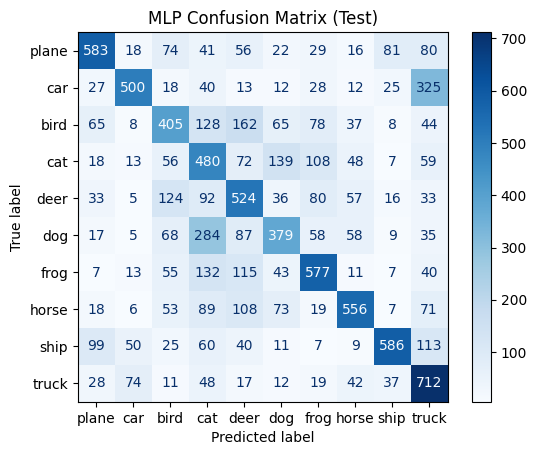

Training CNN...
Epoch 1, Loss: 1.4703086965084076, Accuracy: 47.538%
Epoch 2, Loss: 1.012589140176773, Accuracy: 64.292%
Epoch 3, Loss: 0.8148379688262939, Accuracy: 71.378%
Epoch 4, Loss: 0.6522364819049835, Accuracy: 77.22%
Epoch 5, Loss: 0.5019493426680565, Accuracy: 82.576%
Epoch 6, Loss: 0.3548850614130497, Accuracy: 87.69%
Epoch 7, Loss: 0.23290137150883675, Accuracy: 92.08%
Epoch 8, Loss: 0.14438255118578672, Accuracy: 95.218%
Epoch 9, Loss: 0.08807444970682263, Accuracy: 97.144%
Epoch 10, Loss: 0.06380562803894281, Accuracy: 97.938%
Testing CNN...
Accuracy: 73.99%
Time taken: 662.3167858123779 seconds


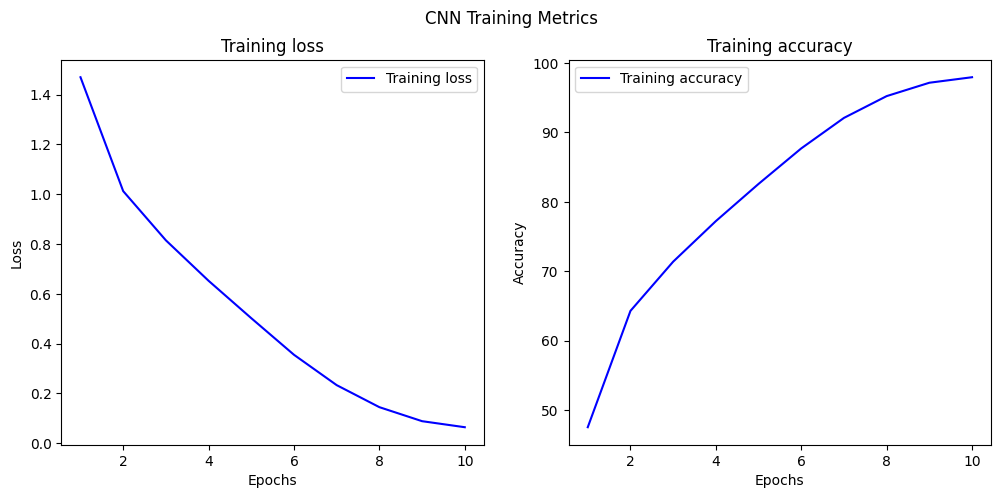

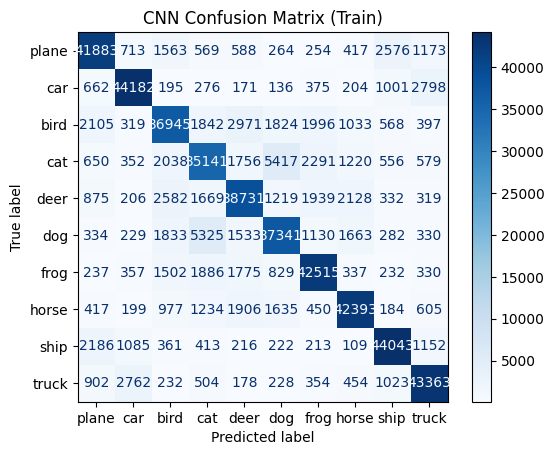

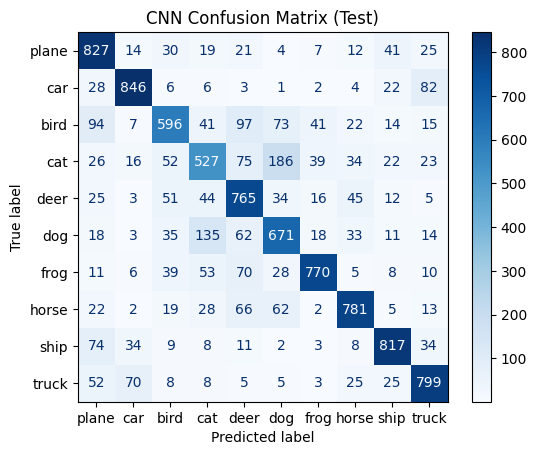

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Définir les transformations pour normaliser les données
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Charger les données CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Définir le modèle MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Définir le modèle CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Fonction pour entraîner le modèle
def train_model(model, trainloader, criterion, optimizer, epochs=15):
    train_loss = []
    train_accuracy = []
    all_preds = []
    all_labels = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        train_loss.append(running_loss / len(trainloader))
        train_accuracy.append(100 * correct / total)
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}, Accuracy: {100 * correct / total}%")
    return train_loss, train_accuracy, all_preds, all_labels

# Fonction pour tester le modèle
def test_model(model, testloader):
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print(f"Accuracy: {100 * correct / total}%")
    return 100 * correct / total, all_preds, all_labels

# Fonction pour afficher les courbes de perte et de précision
def plot_metrics(train_loss, train_accuracy, title):
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
    plt.title('Training accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(title)
    plt.show()

# Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(labels, preds, classes, title):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Fonction pour sauvegarder le modèle au format ONNX
def save_model_onnx(model, filename):
    dummy_input = torch.randn(1, 3, 32, 32)  # Taille d'entrée pour CIFAR-10
    torch.onnx.export(model, dummy_input, filename)

# Entraîner et tester le MLP
mlp = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp.parameters(), lr=0.01, momentum=0.9)

print("Training MLP...")
start_time = time.time()
mlp_train_loss, mlp_train_accuracy, mlp_train_preds, mlp_train_labels = train_model(mlp, trainloader, criterion, optimizer, epochs=10)
print("Testing MLP...")
mlp_test_accuracy, mlp_test_preds, mlp_test_labels = test_model(mlp, testloader)
print(f"Time taken: {time.time() - start_time} seconds")

plot_metrics(mlp_train_loss, mlp_train_accuracy, "MLP Training Metrics")
plot_confusion_matrix(mlp_train_labels, mlp_train_preds, classes, "MLP Confusion Matrix (Train)")
plot_confusion_matrix(mlp_test_labels, mlp_test_preds, classes, "MLP Confusion Matrix (Test)")

save_model_onnx(mlp, "mlp_cifar10.onnx")

# Entraîner et tester le CNN
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9)

print("Training CNN...")
start_time = time.time()
cnn_train_loss, cnn_train_accuracy, cnn_train_preds, cnn_train_labels = train_model(cnn, trainloader, criterion, optimizer, epochs=10)
print("Testing CNN...")
cnn_test_accuracy, cnn_test_preds, cnn_test_labels = test_model(cnn, testloader)
print(f"Time taken: {time.time() - start_time} seconds")

plot_metrics(cnn_train_loss, cnn_train_accuracy, "CNN Training Metrics")
plot_confusion_matrix(cnn_train_labels, cnn_train_preds, classes, "CNN Confusion Matrix (Train)")
plot_confusion_matrix(cnn_test_labels, cnn_test_preds, classes, "CNN Confusion Matrix (Test)")

save_model_onnx(cnn, "cnn_cifar10.onnx")


In [ ]:
mlp_test_accuracy, mlp_test_preds, mlp_test_labels = test_model(mlp, trainloader)


Accuracy: 74.28%


Tout d'abord, les importations nécessaires.

In [ ]:
%%time
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

# partie

batch_size = 32

slurm_project = os.getenv('SLURM_JOB_ACCOUNT')
data_dir = os.path.join('/scratch', slurm_project, 'data') if slurm_project else './data'
print('data_dir =', data_dir)

train_dataset = datasets.CIFAR10(data_dir, train=True, download=True, transform=ToTensor())
test_dataset = datasets.CIFAR10(data_dir, train=False, download=True,transform=ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# partie
for (data, target) in train_loader:
    print('data:', data.size(), 'type:', data.type())
    print('target:', target.size(), 'type:', target.type())
    break

# partie
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )

    def forward(self, x):
        return self.layers(x)

model = SimpleMLP().to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

def correct(output, target):
    predicted_digits = output.argmax(1)                            # choisir le chiffre avec la plus grande sortie du réseau
    correct_ones = (predicted_digits == target).type(torch.float)  # 1.0 pour correct, 0.0 pour incorrect
    return correct_ones.sum().item()


def train(data_loader, model, criterion, optimizer):
    model.train()

    num_batches = len(data_loader)
    num_items = len(data_loader.dataset)

    total_loss = 0
    total_correct = 0
    for data, target in data_loader:
        # Copier les données et les cibles sur le GPU
        data = data.to(device)
        target = target.to(device)

        # Effectuer une passe avant
        output = model(data)

        # Calculer la perte
        loss = criterion(output, target)
        total_loss += loss

        # Compter le nombre de chiffres corrects
        total_correct += correct(output, target)

        # Rétropropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = total_loss/num_batches
    accuracy = total_correct/num_items
    print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}")




epochs = 20
for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    train(train_loader, model, criterion, optimizer)



Using PyTorch version: 2.3.0+cu121
Using GPU, device name: Tesla T4
data_dir = ./data
Files already downloaded and verified
Files already downloaded and verified
data: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
target: torch.Size([32]) type: torch.LongTensor
SimpleMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=20, bias=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=10, bias=True)
  )
)
Training epoch: 1
Average loss: 2.154746, accuracy: 17.38%
Training epoch: 2
Average loss: 2.094723, accuracy: 17.70%
Training epoch: 3
Average loss: 2.080554, accuracy: 17.94%
Training epoch: 4
Average loss: 2.075227, accuracy: 17.90%
Training epoch: 5
Average loss: 2.070210, accuracy: 18.09%
Training epoch: 6
Average loss: 2.066317, accuracy: 18.19%
Training epoch: 7
Average loss: 2.064116, accuracy: 18.41%
Training epoch: 8
Average loss: 2.063363, accuracy: 18.20%
Training epoch: 9
Average loss: 2.05893

In [12]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
import onnx
import onnxruntime

def evaluate_predictions(preds, labels):
    preds = np.argmax(preds, axis=1)
    accuracy = accuracy_score(labels, preds)
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    conf_matrix = confusion_matrix(labels, preds)
    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("F1 Score:", f1)
    return accuracy, recall, f1

def predict_with_onnx(model_path, dataloader):
    session = onnxruntime.InferenceSession(model_path)
    input_name = session.get_inputs()[0].name
    all_preds = []
    all_labels = []

    for inputs, labels in dataloader:
        inputs = inputs.numpy()
        preds = session.run(None, {input_name: inputs})[0]
        all_preds.append(preds)
        all_labels.append(labels.numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_preds, all_labels


# Évaluer les modèles

mlp_model_path = "mlp_cifar10.onnx"
print("Evaluating MLP Autoencoder...")
mlp_preds, mlp_labels = predict_with_onnx(mlp_model_path, testloader)
mlp_accuracy, mlp_recall, mlp_f1 = evaluate_predictions(mlp_preds, mlp_labels)


cnn_model_path = "cnn_cifar10.onnx"
print("Evaluating CNN Autoencoder...")
cnn_preds, cnn_labels = predict_with_onnx(cnn_model_path, testloader)
cnn_accuracy, cnn_recall, cnn_f1 = evaluate_predictions(cnn_preds, cnn_labels)


Evaluating MLP Autoencoder...


InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: onnx::Reshape_0 for the following indices
 index: 0 Got: 100 Expected: 1
 Please fix either the inputs/outputs or the model.

In [ ]:


from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
import onnx
import onnxruntime
session = onnxruntime.InferenceSession(mlp_model_path)
input_name = session.get_inputs()[0].name

### Chargement des données
PyTorch a deux classes de `torch.utils.data` pour travailler avec les données :

- `Dataset` qui représente les éléments de données réels, tels que les images ou les morceaux de texte, et leurs étiquettes.
- `DataLoader` qui est utilisé pour traiter le dataset en lots de manière efficace.

PyTorch dispose de bibliothèques spécifiques à des domaines avec des utilitaires pour des types de données courants comme `TorchText`, `TorchVision` et `TorchAudio`.

Ici, nous allons utiliser `TorchVision` et `torchvision.datasets` qui fournissent un accès facile à de nombreux datasets visuels courants. Dans cet exemple, nous utiliserons la classe MNIST pour charger le dataset MNIST.

In [ ]:
batch_size = 32

slurm_project = os.getenv('SLURM_JOB_ACCOUNT')
data_dir = os.path.join('/scratch', slurm_project, 'data') if slurm_project else './data'
print('data_dir =', data_dir)

#train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=ToTensor())
#test_dataset = datasets.MNIST(data_dir, train=False, transform=ToTensor())

train_dataset = datasets.CIFAR10(data_dir, train=True, download=True, transform=ToTensor())
test_dataset = datasets.CIFAR10(data_dir, train=False, transform=ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

data_dir = ./data


100%|██████████| 170498071/170498071 [00:06<00:00, 26304973.21it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


Les chargeurs de données (`DataLoaders`) permettent de parcourir les datasets, obtenant à chaque fois un nouveau lot de données avec la taille de lot spécifiée.

Le premier élément du lot de données (`data`) est un tenseur de 4e ordre de taille (batch_size, 1, 28, 28), c'est-à-dire qu'il se compose d'un lot d'images de taille 1x28x28 pixels, où la première valeur est le nombre de canaux de couleur (seulement 1 dans ce cas car il s'agit d'une échelle de gris).

Le second élément du lot (`target`) est un vecteur contenant les classes correctes (ou "cibles") ("0", "1", ..., "9") pour chaque chiffre d'entraînement.

In [ ]:
for (data, target) in train_loader:
    print('data:', data.size(), 'type:', data.type())
    print('target:', target.size(), 'type:', target.type())
    break


data: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
target: torch.Size([32]) type: torch.LongTensor


Voici les dix premiers chiffres d'entraînement :

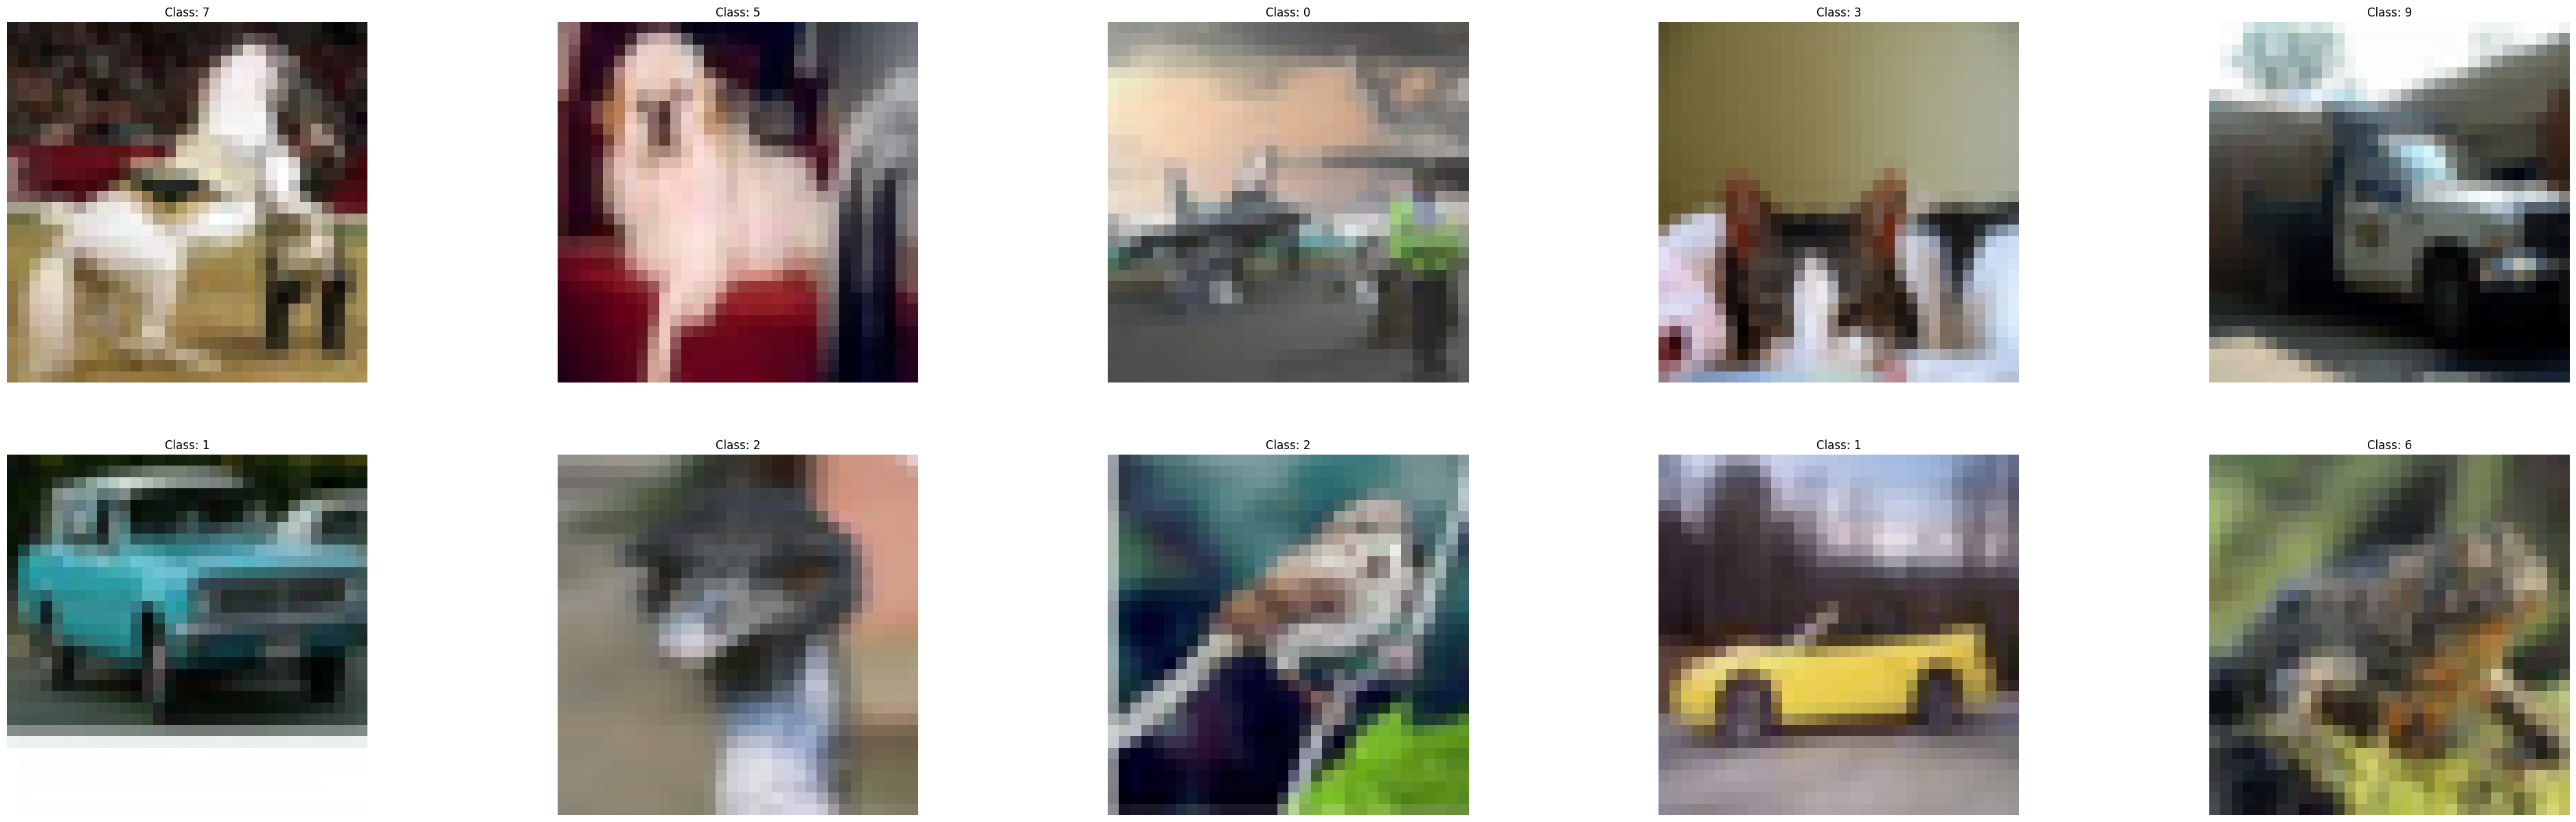

In [ ]:
pltsize=5
plt.figure(figsize=(10*pltsize, 15))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(data[i,:,:,:].numpy(), (1,2,0)))
    plt.title('Class: '+str(target[i].item()))

### Réseau perceptron multicouche (MLP)
Dans PyTorch, un réseau de neurones est défini comme une classe Python. Il doit avoir deux méthodes :

- `__init__()` qui initialise les couches utilisées dans le réseau.
- `forward()` qui définit comment le réseau effectue une passe avant.

PyTorch générera ensuite automatiquement une méthode `backward()` qui calcule les gradients basés sur le calcul effectué dans la passe avant.

Tous les blocs de construction de réseaux de neurones définis dans PyTorch peuvent être trouvés dans la documentation de `torch.nn`.

Nous utilisons `nn.Sequential` pour créer plus facilement un simple réseau neuronal séquentiel :

- Tout d'abord, nous devons "aplatir" l'image 2D en un vecteur avec `nn.Flatten`.
- Ensuite, une couche entièrement connectée avec 20 neurones est créée avec `nn.Linear`. Notez que nous devons spécifier le nombre de connexions d'entrée et de sortie. Dans ce cas, il y a 28x28=784 entrées, et 20 sorties.
- Ensuite, une activation non linéaire ReLU.
- Enfin, la sortie de la dernière couche doit être un vecteur à 10 dimensions pour correspondre à la vérité terrain des dix classes (les dix chiffres).

La sortie de la dernière couche doit être normalisée avec softmax, mais cela est en fait inclus implicitement dans la fonction de perte dans PyTorch (voir ci-dessous).

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )

    def forward(self, x):
        return self.layers(x)

model = SimpleMLP().to(device)
print(model)

### Entraînement du modèle
Pour entraîner le modèle, nous devons définir une fonction de perte et un optimiseur.

Pour une tâche de classification, nous utilisons généralement la perte par entropie croisée (`CrossEntropyLoss`).

Note : si vous lisez attentivement la documentation de `CrossEntropyLoss`, vous verrez qu'elle attend les sorties brutes non normalisées du modèle car softmax est inclus implicitement dans l'implémentation de `CrossEntropyLoss` de PyTorch. C'est pourquoi nous n'avons pas besoin d'utiliser explicitement softmax dans la définition du réseau ci-dessus.

Enfin, nous devons définir un optimiseur, qui indique comment mettre à jour les paramètres du modèle en fonction des gradients calculés. Il existe plusieurs algorithmes d'optimisation implémentés dans PyTorch.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())


Dans PyTorch, nous devons écrire nous-mêmes la boucle d'entraînement.

Le code ci-dessous se compose de deux boucles :

- La boucle externe passe par un certain nombre d'époques. Une époque est un passage complet à travers toutes les données d'entraînement.
- La boucle interne parcourt l'ensemble du dataset, un lot à la fois. Ici, nous avons défini la taille du lot à 32, donc les images sont traitées 32 à la fois.

Pour chaque lot, nous :

- Copions les données sur le GPU avec la méthode `.to(device)`. Si nous n'avons pas de GPU, ces commandes ne feront rien.
- Effectuons une passe avant, ce qui est aussi simple que : `output = model(data)`
- Calculons la perte, c'est-à-dire l'erreur entre la sortie du réseau et la cible que nous voulons obtenir, en utilisant la fonction `criterion` que nous avons définie précédemment.
- Les dernières lignes effectuent la rétropropagation avec `loss.backward()`, les poids sont mis à jour avec `optimizer.step()` et enfin, nous devons réinitialiser les compteurs de gradient avec `optimizer.zero_grad()`.

Tout d'abord, une fonction d'aide pour calculer le nombre de chiffres correctement classés.


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def correct(output, target):
    predicted_digits = output.argmax(1)                            # choisir le chiffre avec la plus grande sortie du réseau
    correct_ones = (predicted_digits == target).type(torch.float)  # 1.0 pour correct, 0.0 pour incorrect

    #cm = confusion_matrix(correct_ones, predicted_digits)
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    #disp.plot(cmap=plt.cm.Blues)
    #plt.show()

    return correct_ones.sum().item()                               # compter le nombre de bons

Ensuite, une fonction pour une seule époque d'entraînement.

In [ ]:

def train(data_loader, model, criterion, optimizer):
    model.train()

    num_batches = len(data_loader)
    num_items = len(data_loader.dataset)

    total_loss = 0
    total_correct = 0
    for data, target in data_loader:
        # Copier les données et les cibles sur le GPU
        data = data.to(device)
        target = target.to(device)

        # Effectuer une passe avant
        output = model(data)

        # Calculer la perte
        loss = criterion(output, target)
        total_loss += loss

        # Compter le nombre de chiffres corrects
        total_correct += correct(output, target)

        # Rétropropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()



    train_loss = total_loss/num_batches
    accuracy = total_correct/num_items


    print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.7f}")
    return accuracy, loss

In [ ]:
%%time

epochs = 20
loss = []
accuracy = []
for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    acc, train_loss = train(train_loader, model, criterion, optimizer)
    loss.append(train_loss)
    accuracy.append(acc)

### Inférence
Pour une meilleure mesure de la qualité du modèle, voyons la précision du modèle pour les données de test.

Le code est similaire à celui de l'entraînement : nous parcourons simplement tout l'ensemble de test, mais il n'est pas nécessaire de faire de rétropropagation ni de calculer des gradients cette fois-ci.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def test(test_loader, model, criterion):
    model.eval()

    num_batches = len(test_loader)
    num_items = len(test_loader.dataset)

    test_loss = 0
    total_correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
      for data, target in test_loader:
          # Copier les données et les cibles sur le GPU
          data = data.to(device)
          target = target.to(device)

          # Effectuer une passe avant
          output = model(data)

          # Calculer la perte
          loss = criterion(output, target)
          test_loss += loss.item()

          # Compter le nombre de chiffres corrects
          total_correct += correct(output, target)

          all_preds.append(output.cpu().numpy())
          all_labels.append(target.cpu().numpy())


      cm = confusion_matrix(all_labels, all_preds)
      disp = ConfusionMatrixDisplay(confusion_matrix=cm)
      disp.plot(cmap=plt.cm.Blues)
      plt.show()


    test_loss = test_loss/num_batches
    accuracy = total_correct/num_items

    print(f"Testset accuracy: {100*accuracy:>0.1f}%, average loss: {test_loss:>7f}")

test(test_loader, model, criterion)

### Tâche 1 : Modèle avec deux couches linéaires
Votre tâche est d'essayer le même problème qu'au-dessus, mais avec un modèle plus complexe. Le nouveau modèle doit avoir deux couches linéaires, chacune avec :

- 50 unités
- Activation ReLU
- Suivie d'une couche de dropout avec un taux de 0.2 - astuce : essayez `nn.Dropout`

Le Dropout définit aléatoirement une fraction des entrées à zéro pendant l'entraînement, ce qui est une approche de régularisation et peut parfois aider à éviter le surapprentissage.

Vous pouvez consulter la documentation de PyTorch, en particulier tous les blocs de construction de réseaux de neurones peuvent être trouvés dans la documentation de `torch.nn`.

Le code ci-dessous manque de la définition du modèle. Vous pouvez copier les couches appropriées de l'exemple ci-dessus.

```python

```

In [ ]:
class TwoLayerMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        return self.layers(x)

ex1_model = TwoLayerMLP()
print(ex1_model)

assert len(ex1_model.layers) > 0, "ERROR: You need to write the missing model definition above!"
ex1_model = ex1_model.to(device)
ex1_criterion = nn.CrossEntropyLoss()
ex1_optimizer = torch.optim.Adam(ex1_model.parameters())



In [ ]:
%%time

loss = []
accuracy = []

epochs = 10
for epoch in range(epochs):
    print(f"Epoch: {epoch+1} ...")

    acc, train_loss = train(train_loader, ex1_model, ex1_criterion, ex1_optimizer)
    loss.append(train_loss)
    accuracy.append(acc)

test(test_loader, ex1_model, ex1_criterion)

### Tâche 2 : Réglage du modèle
Modifiez le modèle MLP. Essayez d'améliorer la précision de classification ou d'expérimenter les effets de différents paramètres. Si vous êtes intéressé par les performances de pointe sur MNIST invariant aux permutations, voir par exemple cet article des chercheurs de l'Université Aalto / The Curious AI Company.

### Tâche 3 : Fashion-MNIST
MNIST peut être remplacé par Fashion-MNIST, qui peut être utilisé comme un remplacement direct pour MNIST. Fashion-MNIST contient des images de 10 catégories de mode :

| Étiquette | Description  | Étiquette | Description    |
|-----------|--------------|-----------|----------------|
| 0         | T-shirt/top  | 5         | Sandale        |
| 1         | Pantalon     | 6         | Chemise        |
| 2         | Pull-over    | 7         | Basket         |
| 3         | Robe         | 8         | Sac            |
| 4         | Manteau      | 9         | Bottine        |

Remplacez le chargement des données MNIST par Fashion-MNIST au début de ce notebook et relancez les expériences. Fashion-MNIST peut être trouvé avec la classe de dataset `FashionMNIST`.

```python
train_dataset = datasets.FashionMNIST(data_dir, train=True, download=True, transform=ToTensor())
test_dataset = datasets.FashionMNIST(data_dir, train=False, transform=ToTensor())
```

Puis, re-entraînez et testez votre modèle comme vous l'avez fait pour MNIST.

# **Autoencodeur avec MLP**

Un autoencodeur comporte une partie encodage (compression) et une partie décodage (reconstruction). Nous allons utiliser une architecture simple avec des couches linéaires et des fonctions d'activation ReLU pour l'encodage et le décodage.

Using PyTorch version: 2.3.0+cu121
Using GPU, device name: Tesla T4
data_dir = ./data
Files already downloaded and verified
data: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
target: torch.Size([32]) type: torch.LongTensor
Autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=12, bias=True)
    (6): ReLU()
    (7): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=3072, bias=True)
    (7): Sigmoid()
  )
)
Training epoch: 1
Average loss: 0.037441
Training epoc

TypeError: Invalid shape (3, 32, 32) for image data

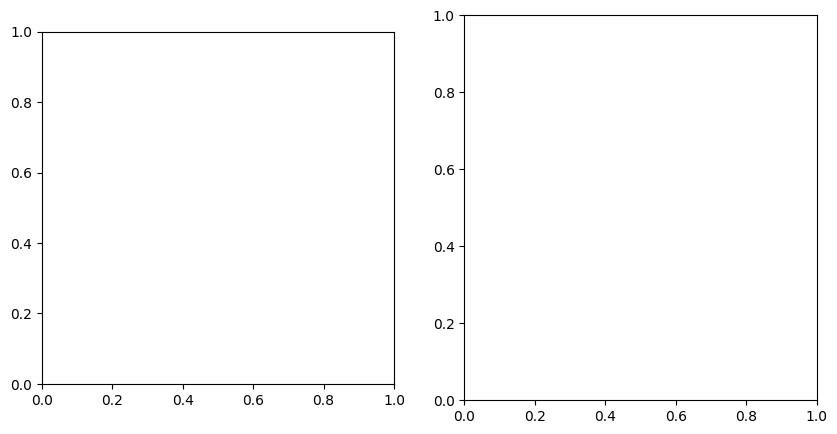

In [ ]:

%%time
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
import os

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

# Chargement des données
batch_size = 32

slurm_project = os.getenv('SLURM_JOB_ACCOUNT')
data_dir = os.path.join('/scratch', slurm_project, 'data') if slurm_project else './data'
print('data_dir =', data_dir)

train_dataset = datasets.CIFAR10(data_dir, train=True, download=True, transform=ToTensor())
test_dataset = datasets.CIFAR10(data_dir, train=False, transform=ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Vérification des données
for (data, target) in train_loader:
    print('data:', data.size(), 'type:', data.type())
    print('target:', target.size(), 'type:', target.type())
    break

# Définition de l'autoencodeur
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 32 * 32*3),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder().to(device)
print(model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Fonction de formation
def train(data_loader, model, criterion, optimizer):
    model.train()
    num_batches = len(data_loader)
    total_loss = 0

    for data, _ in data_loader:
        data = data.to(device)

        # Effectuer une passe avant
        output = model(data)

        # Calculer la perte
        loss = criterion(output, data.view(-1, 32 * 32*3))
        total_loss += loss.item()

        # Rétropropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = total_loss / num_batches
    print(f"Average loss: {train_loss:.6f}")

# Entraînement de l'autoencodeur
epochs = 10
for epoch in range(epochs):
    print(f"Training epoch: {epoch + 1}")
    train(train_loader, model, criterion, optimizer)

# Visualisation des résultats
def visualize(model, data_loader):
    model.eval()
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            output = model(data)
            output = output.view(-1, 3, 32, 32).cpu().numpy()
            break

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(data[0].cpu().numpy().squeeze(), cmap='gray')
    axes[0].set_title('Original Image')
    axes[1].imshow(output[0].squeeze(), cmap='gray')
    axes[1].set_title('Reconstructed Image')
    plt.show()

# Visualiser les résultats sur le jeu de test
visualize(model, test_loader)

In [ ]:
visualize(model, test_loader)


### Explications des modifications :
1. **Chargement des données** : Chargement et transformation des données MNIST comme dans l'original.
2. **Autoencodeur** : Création de la classe `Autoencoder` avec des couches d'encodage et de décodage.
3. **Critère et Optimiseur** : Utilisation de `nn.MSELoss()` pour minimiser l'erreur quadratique moyenne entre les images d'entrée et les reconstructions. Utilisation de `torch.optim.Adam` pour une convergence stable.
4. **Fonction de formation** : Adaptation de la fonction de formation pour entraîner l'autoencodeur.
5. **Entraînement** : Entraînement du modèle sur 10 époques.
6. **Visualisation** : Ajout d'une fonction pour visualiser les images originales et reconstruites.

Ce code entraîne un autoencodeur sur le dataset MNIST pour apprendre une représentation comprimée des images, puis les reconstruit pour évaluer la qualité de l'autoencodeur.

**Remarques**

Le dataset MNIST est constitué d'images en niveaux de gris, où chaque pixel a une valeur entre 0 et 255. Lors de la transformation avec `ToTensor()`, ces valeurs sont normalisées entre 0 et 1. C'est pourquoi il est approprié d'utiliser la fonction d'activation `Sigmoid` à la fin du décodeur. La fonction `Sigmoid` comprime ses entrées dans l'intervalle (0, 1), ce qui correspond à la plage de valeurs normalisées des pixels des images MNIST.

Cela garantit que les valeurs des pixels reconstruits par l'autoencodeur sont également dans la même plage, facilitant ainsi la comparaison entre les images originales et reconstruites en termes de perte.

Voici un rappel du segment de code pertinent :

```python
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Sigmoid pour s'assurer que la sortie est entre 0 et 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
```

En utilisant `Sigmoid` à la fin du décodeur, nous nous assurons que les valeurs des pixels reconstruits restent dans l'intervalle [0, 1], ce qui est cohérent avec les valeurs normalisées des pixels des images d'entrée.

Si vous avez des questions supplémentaires ou des ajustements à faire, n'hésitez pas à demander !